# Activity 3 - Fourier Transform of a Raw FID
In this activity we will finish up our exploration of the Fourier Transform by using a combination of Python libraries and techniques from previous activites to perform a Fourier Transform on raw free induction decay (FID) data to generate an $^1$H NMR spectra of the compound.

For this activity, you will need to use an external data file. This file is provided to you, and it should be downloaded and saved to a known location prior to beginning this activity.

To upload it, use the toolbar along the left side and select the folder icon. This should open the files panel. Select the first button (looks like a page with an up-arrow in it) to upload a file. Navigate to the location you saved the file and upload it here. The warning can be ignored, but every time you load into this activity, you will need to reupload the file, so do not delete it.

Finally, right click on the file and make sure it is named `ascii-fid.txt`.

## Learning Objectives:
* Customizing the appearance of generated graphs and figures
* Opening and using a file's contents
* Manipulating data using mathematical techniques
* Using Python libraries to Fourier Transform real world data
* Understanding how different techniques are used to refine data for use in the Fourier Transform

In this activity, `?`s have been used to represent values or variable names which need replacing. Do not replace or rewrite any of the code other than what is marked with a `?`. The code will run without errors if you replace the `?`s with the correct values.

Also, this activity will involve a lot of variables which will be important for plotting. Therefore, we have not removed any of the variable names, and provided all of the `plt.plot(x_axis, y_axis)` based code for you.

# Part 1: Setting Up Our Environment

We will be using the same libraries in this exercise as we have previously. Additionally, you can customize the appearance of your graph using `rcParams`; some examples are shown below, but for a full guide, click [this link](https://matplotlib.org/stable/users/explain/customizing.html#runtime-rc-settings).

In [1]:
# Import libraries below
import numpy as np
import matplotlib.pyplot as plt

# Customize plotting parameters
plt.rcParams["font.size"] = 12
plt.rcParams['font.family'] = 'serif'

## Opening a File
Now, to open the data file containing our raw FID data, we will use `np.loadtxt()` to open our file and store it as an array which we can use as we have previously.

`np.loadtxt()` can take up to 14 different parameters, but we are only interested in two. The first is our filename, specified in quotations, and the second is the character used to separate our y-values from our x-values. If you open the file, we see that this character is a comma, so our `loadtxt` command will look like the following:
```
data = np.loadtxt("ascii-fid.txt", delimiter=",").T
```
We will also transpose our array using the `.T` operator after our `np.loadtxt()` command as this will be helpful for working with our data later. This operation will transform our data from something like this:
$$\begin{bmatrix}a & b \\ c & d \\ e & f\end{bmatrix}$$ to something like this: $$\begin{bmatrix}a & c & e \\ b & d & f\end{bmatrix}$$

Finally, we will assign each row to a variable, but since we will not be referencing the first row (the indices 1, 2, 3, etc.) we can assign that row a variable name of `indices`, whereas the other row will be our `fid` variable. This can be done with the line:
```
indices, fid = data
```
Finally, print the length of the FID using `len()` and confirm that it matches the length of the input data (32768).

In [2]:
# Load in the dataframe and store as a variable called data
data = np.loadtxt("ascii-fid.txt", delimiter=",").T
indices, fid = data

# Print the length of the FID
print(len(fid))

32768


If you've never seen a raw FID before, it may be helpful to plot this one to have an idea of the type of graph we will be modifying in the following steps. Plot the FID using the `indices` as the x-values. Do not forget to label your graph and axes, as have been done previously.

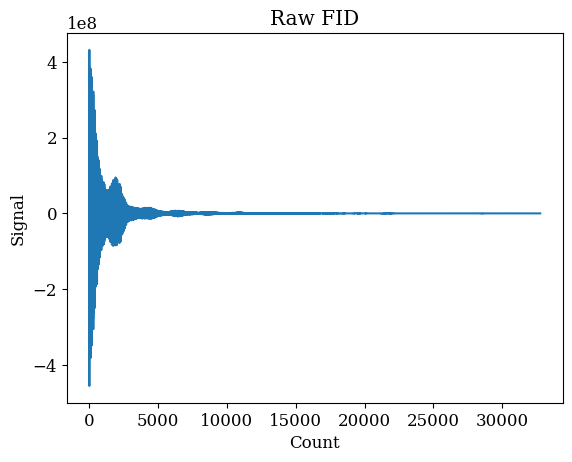

In [3]:
plt.plot(indices,fid)
plt.title('Raw FID')
plt.xlabel('Count')
plt.ylabel('Signal')
plt.show()

While the graph may look like a blob at first, try zooming in to better visualize the oscilation pattern. Set the axis to view the first 1000 points to see the function decay, then set it lower to see distinct lines. Remeber, you can use `plt.xlim(LOWER, UPPER)` to zoom your $x$-axis.

Also note that the axes have been labeled using the `plt.xlabel(NAME)` and `plt.ylabel(NAME)` commands. Specifically, the $x$-axis is the count; this is *not* a timestep and later we will need to convert it into one. Instead, this can be thought of as an enumeration of points, i.e., the first point was $p_1$, the second point was $p_2$, etc.

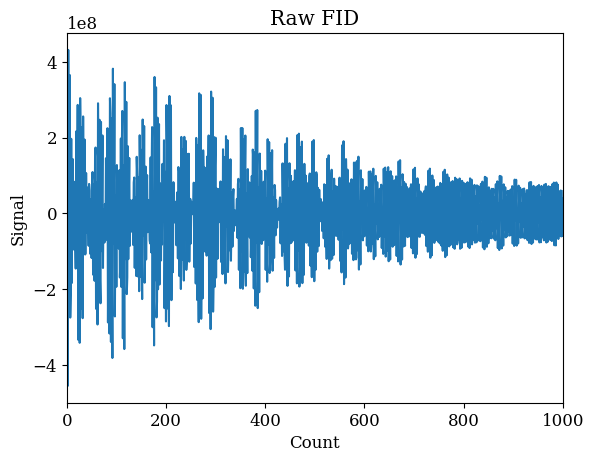

In [4]:
plt.plot(indices,fid)
plt.title('Raw FID')
plt.xlabel('Count')
plt.ylabel('Signal')
plt.xlim(0, 1000)
# plt.xlim(0,100)
plt.show()

### Question 1
1. Why do you think the Fourier Transform will not work properly with an enumeration of points?

**The FT requires a signal to be in the time-domain and each point should be separated by a precise timestep starting from t=0. If the points are given as an enumeration instead, the time for the acquisition is artifically inflated and will not relate properly to frequency when the FT is applied.**

## Setting Initial Variables
We first need to define some variables to help work with our dataset a bit better.

All NMR instruments have a reference frequency, often measured in MHz, and instruments with higher frequencies tend to produce higher resolution spectra. The reference frequency of the NMR used to collect the data for this lab was  500 MHz, so we will define a variable below to represent that value.

In [5]:
# Define the reference frequency of the instrument:
ref_freq_500 = 500 * 10**6 # Hz

As a brief reminder, recall that the frequency data which will be generated from the Fourier Transform will be in Hz ($s^{-1}$), but that NMR spectra show it in ppm. Shown below is an electromagnetic spectrum diagram to help you better understand where the NMR frequency falls on the complete spectrum.

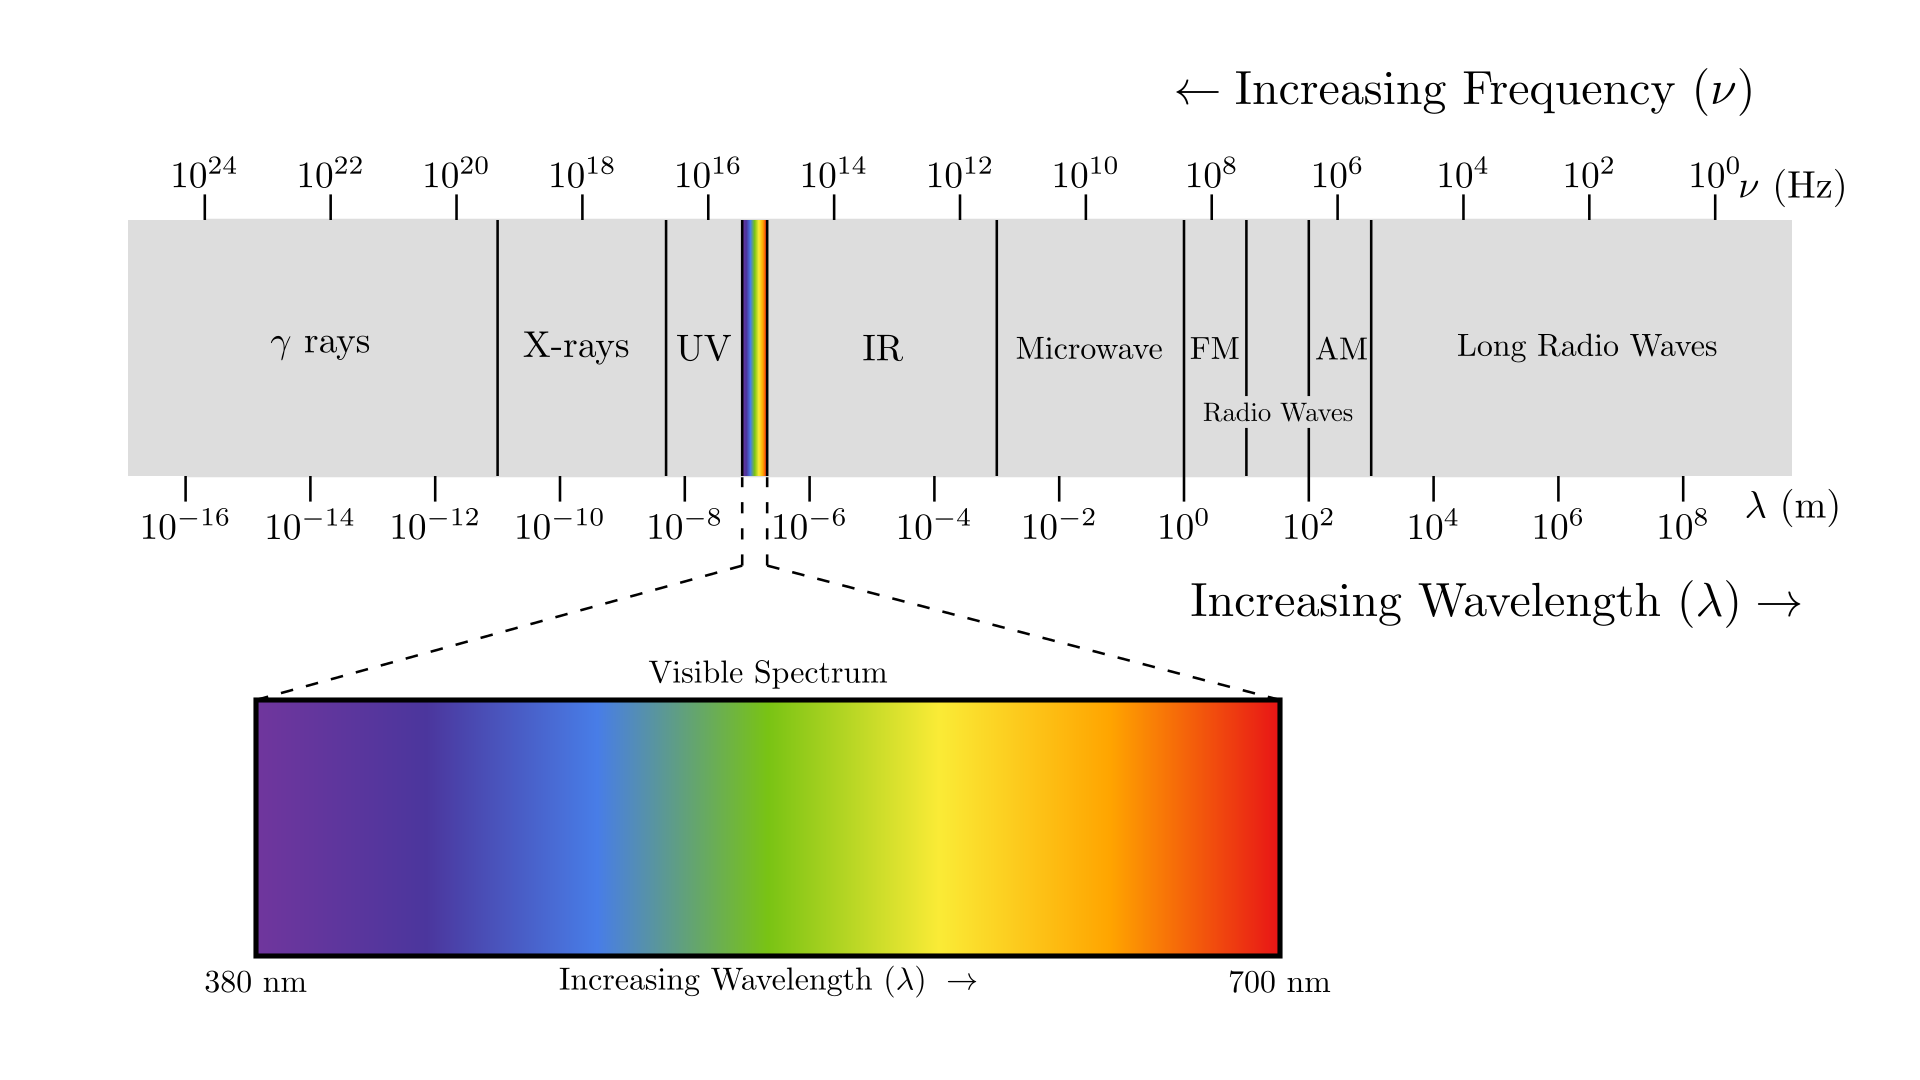

The NMR used for this experiment is a 500 MHz NMR, which is about right in the middle of radio waves. Using $E = h\nu$, where $h = 6.626 * 10^{-34}~\text{J/s}$, we can determine how much energy these waves contain.

\begin{align}
E &= 6.626 * 10^{-34}~\text{J/s} * 500 * 10^{6}~\text{s}^{-1}\\
E &= 3.313*10^{-25}~\text{J}
\end{align}

Or not all that much energy. We often don't think of energies of these transitions because the x-axis we typically use in NMR spectroscopy is chemical shift, which is a relative metric given in ppm. We know that ppm is relative because often one of the first things done when analyzing an NMR spectrum is to reference a molecule such as TMS ($\text{Si(CH}_3\text{)}_4$) to the value 0 ppm. From there, a $\delta$ value can be determined as follows:

$$\delta = \frac{\text{frequency of signal}-\text{frequency of standard}}{\text{spectrophotometer frequency}} * 10^6$$

Other times, residual solvent peaks are used to reference spectra to a particular value, e.g., using 7.26 ppm for the proton in chloroform ($\text{CHCl}_3$).

### Questions 2, 3
2. How much energy would a pulse from a 250 MHz NMR instrument contain?
**$1.656~\text{J}$ of energy would be contained in a single pulse from a 250 MHz instrument.**

3. On a particular 500 MHz spectrometer, a proton on a molecule produces a frequency of 9.5 kHz and it is known that TMS produces a frequency of 5.9 kHz. What is the equivalent ppm of the unknown proton? What region of a proton NMR does it fall in?
**The unknown proton would be at 7.2 ppm, which is in the "aromatic region" of a proton NMR spectra.**

Next, to solve the issue with our x-axis being indices, we will generate a time array which matches the acquisition parameters. To do this, first define a `duration` variable equal to the ''AQ [sec]'' value from the image of the acquisition parameters provided with the FID dataset. Assign the length of the FID to `num_steps`. The length of any dataset can be determined using `len(DATASET)`.

Recall that our `np.arange` takes three parameters, and while we have the first two, we will need to calculate the final parameter, `dt`.

Do this using the previously defined variables and then print it to see how often the instrument took a measurement (it is probably more helpful to convert this value to miliseconds when you print it).

In [6]:
# Define duration and num_steps from the acquisition file
duration = 2.0447233
num_steps = len(fid)

# Calculate the dt
dt = duration / num_steps
print(dt * 10**3, "ms") # convert to miliseconds

0.06240000305175781 ms


### Question 4
4. What value (in milliseconds) did you get for `dt`?

**Students should get `0.06240000305175781 ms`.**

Finally, make your `time_array` as done previously.

In [7]:
# Initialize the time_array
time_array = np.arange(0, duration, dt)

We will now plot the time array and the FID data together to visualize the new FID we are working with. Note how the values of the $x$-axis have changed from  the FID above (before defining the `time_array`).

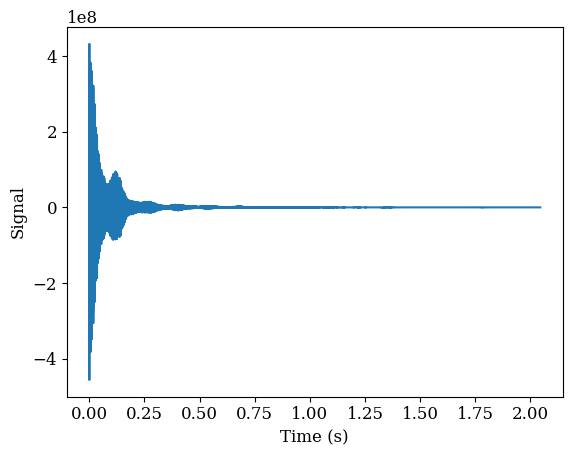

In [8]:
# Plot the FID using the newly defined time_axis
plt.plot(time_array, fid)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.show()

# Part 2: Data Modification and Optimization
In this section, we will modify our dataset to make our final Fourier Transform more resolvable and increase the signal-to-noise ratio. The modifications we will make, such as zero padding and windowing, are commonly made by the spectroscopy software before the resulting spectra is even displayed.

We will also compare these techniques to see how they impact our final spectra. Since we will be comparing our modified data to the original dataset, it is important to not modify your original FID directly, but to always save your modifications as new variables.

For example, to add 10 to the FID, do this:
```
original_fid = ...
fid_plus_ten = original_fid + 10
```
and do **NOT** do the following:
```
original_fid = original_fid + 10
```

## Shifting the Dataset
One of the conditions which must be satisfied by the input function for the Fourier transform to work is that it *must* decay to zero. Our FID dataset appears to be symmetric about the x-axis (y = 0), but in reality, this is not the case; it is actually symmetric about some y-value *very close* to zero, so we need to shift it.

To adjust for this, calculate the mean of the `fid` data and subtract that mean value from each data point.

In [9]:
# compute the mean of the data
mean = np.mean(fid)
print(mean)

# subtract the mean from the data
sub_fid = fid - mean # or fid = fid - mean

-798.7989501953125


## Zero Padding
A common technique to improve the resolution of the data without adjusting any of the datapoints is *zero padding*, also called "zero filling." This technique is also used to speed up the FFT when working with very large datasets, and it does so by adding zeros to the end of the dataset such that the length is a power of 2. For those interested in the mathematical details of this technique, these concepts are covered in more depth in Chapter 12 of "Numerical Recipes in C" by William H. Press, Saul A. Teukolsky, William T. Vetterling, and Brian P. Flannery.

Below we have provided code to zero pad our signal as well as adjust our time axis.

In [10]:
# Zero-fill (zf) below:
zf_fid = np.pad(sub_fid, (0, num_steps), 'constant')
zf_fid_length = len(zf_fid)
new_tmax = zf_fid_length * dt

print("length of new array is:", zf_fid_length)
print("log2 of new array is:", np.log2(zf_fid_length))

length of new array is: 65536
log2 of new array is: 16.0


Since zero padding changes the length of the original dataset, we must calculate a new time array, which is done below for you.

In [11]:
# Calculates the new time_array for you:
zf_time_array = np.arange(0, new_tmax, dt)

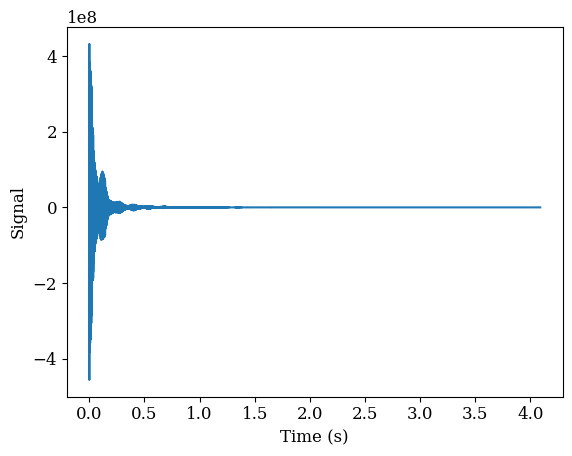

In [12]:
# Plot the new FID dataset below
plt.plot(zf_time_array, zf_fid)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.show()

### Questions 6, 7
6. What effect did zero-padding have on the FID?
**The length of the FID was doubled.**
7. Why did we have to calculate a new `time_array`?
**Since the FID had many zeroes added to the end, we needed to add time values which corresponded to all of those zeroes.**

## Implementing a Windowing Function
We will now explore the use of a windowing function to increase the signal-to-noise (S/N) ratio. In this section, we will implement two such functions, the exponential and the Hann.

The first window to implement is the exponential window which is done by first generating a window of the appropriate length and a few other parameters corresponding to the exponential window:
```
exp_window = sci.exponential(len(zf_fid), tau=1000, sym=False, center=0))
```
And then the fid is adjusted by multiplying all of the values in the FID by that window using:
```
exp_fid = zf_fid * exp_window
```
This window was originally used for filtering climate timeseries but has good properties when working with data in the spectral domain.

For more info on the Exponential Window, see [here](https://en.wikipedia.org/wiki/Window_function).

Below, create the window, adjust the FID, and plot the data to visualize the change (*note:* it may look a little strange).

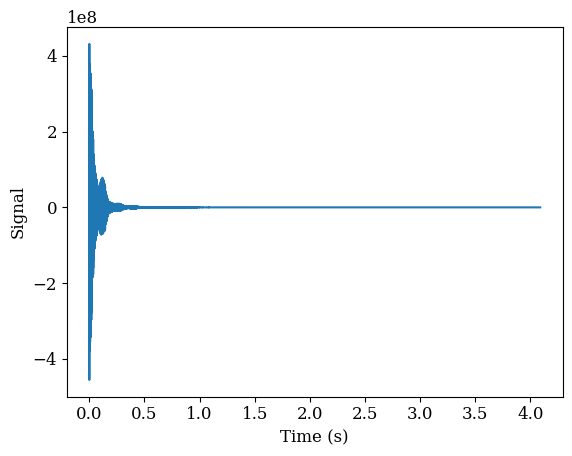

In [13]:
import scipy.signal.windows as sci

# Create the Exponential Window
#lanczos_window = sci.lanczos(len(zf_fid)) # Alternatively, onoe could employ the Lanczos window
exp_window = sci.exponential(len(zf_fid), tau=10000, sym=False, center=0)

# Multiply the data by it
exp_fid = zf_fid * exp_window

# Plot the updated fid
plt.plot(zf_time_array, exp_fid)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.show()

We will also implement the Hann Function, which is a common function used to avoid abrupt decays to zero in the original dataset. This is done by raising the negative portions of a cosine period to be zero.

For more information on the Hann Function, see [here](https://ccrma.stanford.edu/~jos/sasp/Hann_Hanning_Raised_Cosine.html).

To apply this function, we can use `np.hanning(LENGTH)` to generate a window of the correct size, then apply this window to our original FID data by multiplying it by our original dataset. We can again plot this data to visualize the effect.

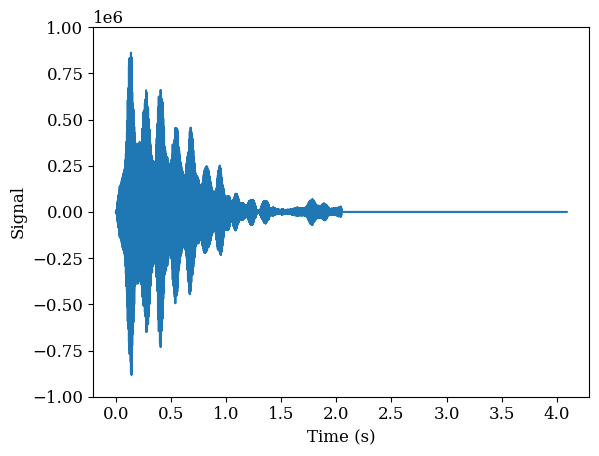

In [14]:
# Apply the Hanning window as before
hanning_window = np.hanning(len(zf_fid))
hanning_fid = zf_fid * hanning_window

plt.plot(zf_time_array, hanning_fid)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.ylim(-1E6, 1E6)
plt.show()

## Fourier Transform Time!
We have now prepared all of our datasets for Fourier Transform and can use `numpy`'s built-in "Fast Fourier Transform," or FFT, which was explored in Activity 2.

In [15]:
# Perform FFT on original FID
spectrum = np.fft.rfft(zf_fid)

# Perform FFT on the exponentially Windowed FID
exp_spectrum = np.fft.rfft(exp_fid)

# Perform FFT on the Hanning Windowed FID
hanning_spectrum = np.fft.rfft(hanning_fid)

Calculate the corresponding frequency axes, as shown in Activity 2

In [16]:
# Original
frequencies = np.fft.rfftfreq(len(zf_fid), d=dt)

# Exponential Window
exp_frequencies = np.fft.rfftfreq(len(exp_fid), d=dt)

# Hanning Window
hanning_frequencies = np.fft.rfftfreq(len(hanning_fid), d=dt)

Finally, plot the three transforms. The code below will use `subplots` to plot all three graphs within the same figure. The axes and title are labeled for you, all you need to add is the variable names for the three frequency axes and the three FT values.

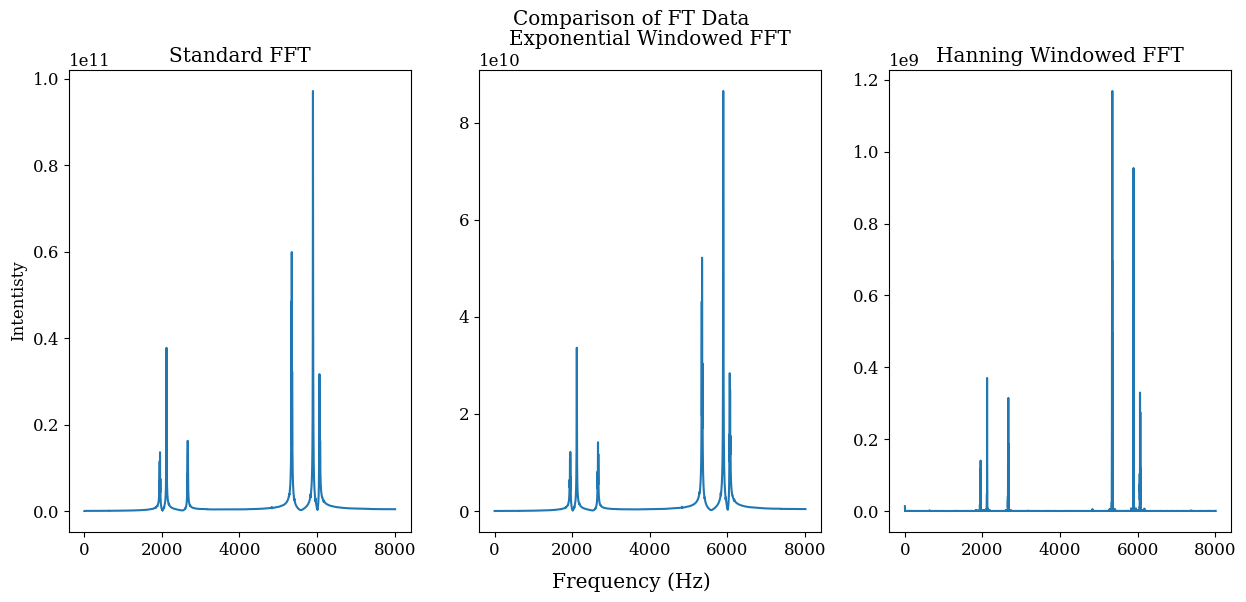

In [17]:
# Plot Side-by-Side:
fig, (left, center, right) = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle("Comparison of FT Data")
fig.supxlabel("Frequency (Hz)")
left.set_ylabel("Intentisty")

# Standard FFT
left.set_title("Standard FFT")
left.plot(frequencies, np.abs(spectrum))

# Exponential Window Function
center.set_title("Exponential Windowed FFT")
center.plot(exp_frequencies, np.abs(exp_spectrum))

# Hanning Window Function
right.set_title("Hanning Windowed FFT")
right.plot(hanning_frequencies, np.abs(hanning_spectrum))

plt.show()

What are your initial impressions of how the three spectra compare to each other?

We will now normalize the spectra to set the y-axis maximum value to be `1.0`. To do this, first take the absolute value of the spectra using `np.abs`, then in the same line of code, find the maximum using `.max()` and store this as a value. Repeat for each spectra.

In [18]:
# Original spectrum max
spectrum_max = np.max(np.abs(spectrum))

# Exponential spectrum max
e_spectrum_max = np.max(np.abs(exp_spectrum))

# Hanning spectrum max
h_spectrum_max = np.max(np.abs(hanning_spectrum))

To finish normalizing, take the absolute value of the three spectra and divide it by the corresponding maximum value. This will turn our values into a percent-of-max which will ensure no value exceeds `1.0`.

In [19]:
norm_spec = np.abs(spectrum)/spectrum_max
e_norm_spec = np.abs(exp_spectrum)/e_spectrum_max
h_norm_spec = np.abs(hanning_spectrum)/h_spectrum_max

We will also convert our x-axis from MHz to ppm by dividing the frequency values by the refrence frequency of the instrument, then multiplying by one million.

In [20]:
freq_ppm = frequencies / ref_freq_500 * 10**6
e_ppm = exp_frequencies / ref_freq_500 * 10**6
h_ppm = hanning_frequencies / ref_freq_500 * 10**6

We can now plot the three normalized spectra against one another to get a better comparison of the effects of zero-padding and windowing. You will need to zoom in to better see these effects.

Note that zooming is a bit different with the subplot based spectra. To zoom in on a graph, instead of using `plt.xlim(LOWER, UPPER)` you use `set_xlim(LOWER, UPPER)` on the axes. So to zoom in on the middle figure you would use:
```
center.set_xlim(4.7, 5.3)
center.set_ylim(0.0, 0.4)
```

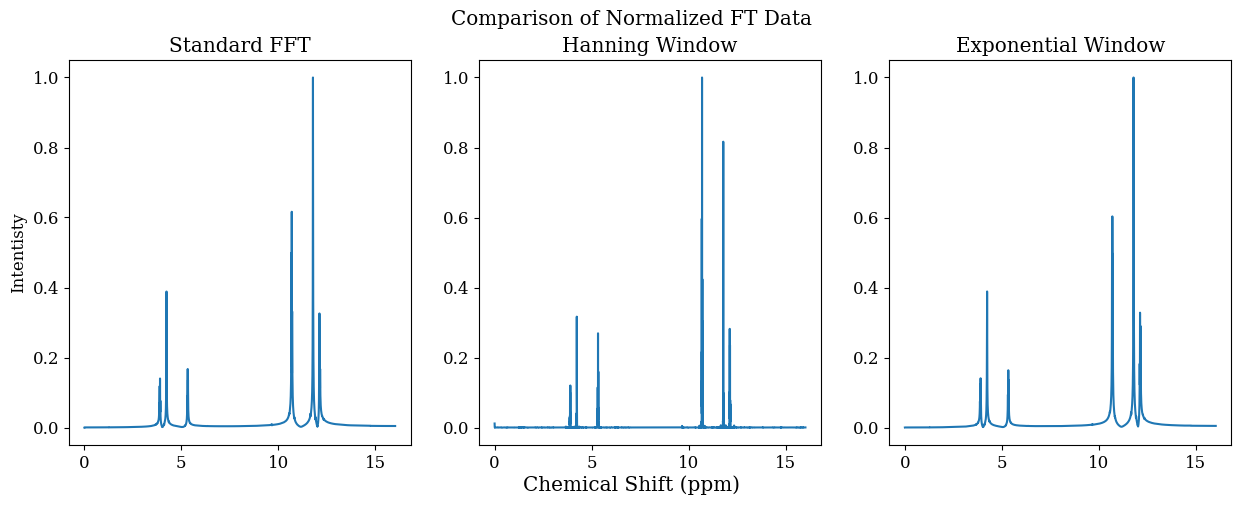

In [21]:
# Plot Side-by-Side (normalized):
fig, (left, center, right) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Comparison of Normalized FT Data")
fig.supxlabel("Chemical Shift (ppm)")
left.set_ylabel("Intentisty")

# Standard FFT
left.set_title("Standard FFT")
left.plot(freq_ppm, np.abs(norm_spec))

# Hanning Window Filled FFT
center.set_title("Hanning Window")
center.plot(h_ppm, np.abs(h_norm_spec))

# Exponential Window Function
right.set_title("Exponential Window")
right.plot(e_ppm, np.abs(e_norm_spec))

plt.show()

### Question 8
8. Qualitatively, how do the three spectra compare to each other? Specifically discuss differences in peak width, height, resolution. You will want to refer to both the normalized and unnormalized plots to answer this question.

**The standard FFT plot has the broadest peaks by far, followed by the Exponential, then the Hanning. In the normalized plots, the Hanning signals are the smallest, with the Exponential and the Standard having a slightly larger height for some peaks and smaller for others. In the unnormalized plots, the standard is substantially (2 orders of magnitude) higher than the other two. Finally, the resolution of the Hanning window is much higher than the Exponential and the Standard, but it could be argued that this increase is *too* high (to visualize, zoom all three plots to x-limits of (5, 5.5))**

## Cleaning Up the Spectra:
Notice how the three NMR spectra shown above don't quite look like the spectra we are familiar with. For one, the ppm axis is going the wrong way, and secondly, there seems to be a smaller mirrored version of the spectra on the left. Below, we will address both of these issues.

Due to the math behind the FFT, when you take the FFT of a real valued dataset, the output is always mirrored. To adjust for this, we will use the pre-made reference function below to properly reference our signals to the TMS signal. We will then use `plt.gca().invert_xaxis()` to flip the x-axis so that zero is on the right. The reference function works like the `update` function from activity 1, and does not require any modifications; simply run the cell.


In [22]:
def reference(freq_ppm, signal):
    """
    Args:
        freq_ppm - The frequency values of the spectra (in ppm)
        signal - The intensity data which should be referenced (normalized)
    """
    # Find midpoint and clip spectra
    mid_ppm = len(freq_ppm)//2
    positive_freq_ppm = freq_ppm[mid_ppm:]
    positive_signal = signal[mid_ppm:]

    # TMS is located between 9.6 and 9.7 before referencing
    lower_bound = np.abs(positive_freq_ppm - 9.6).argmin()
    upper_bound = np.abs(positive_freq_ppm - 9.7).argmin()

    # Find the index of TMS in the frequency axis
    tms_containing_spec = norm_spec[lower_bound:upper_bound]
    peak_index_in_segment = np.argmax(tms_containing_spec)
    peak_index_in_norm_spec = lower_bound + peak_index_in_segment

    # Return shifted spectra and frequency axis
    final_spec = positive_signal[peak_index_in_norm_spec:]
    final_ppm = positive_freq_ppm[peak_index_in_norm_spec:] - freq_ppm[peak_index_in_norm_spec] - freq_ppm[mid_ppm]

    return final_ppm, final_spec

To use the reference function, make a variable for the new ppm axis and the new spectrum data and then call reference as follows:
```
new_ppm, new_spectrum = reference(old_ppm, old_spectrum)
```

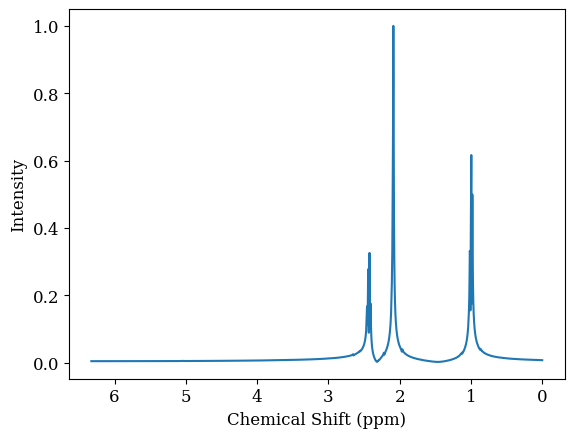

In [23]:
# Reference and plot the unmodified spectrum to confirm it is referenced properly
standard_ppm_ref, standard_spec_ref = reference(freq_ppm, norm_spec)

plt.plot(standard_ppm_ref, standard_spec_ref)
plt.gca().invert_xaxis()
plt.ylabel("Intensity")
plt.xlabel("Chemical Shift (ppm)")
plt.show()

In [24]:
# Reference the Exponential Window Function
e_ppm_ref, e_signal_ref = reference(e_ppm, e_norm_spec)

# Reference the Hanning Window Function
h_ppm_ref, h_signal_ref = reference(h_ppm, h_norm_spec)

Finally, using `subplots`, plot all three NMR spectra together.

When working with subplots, you can invert the x-axis using `.invert_xaxis()` after the axis name, like:
```
left.invert_xaxis()
```

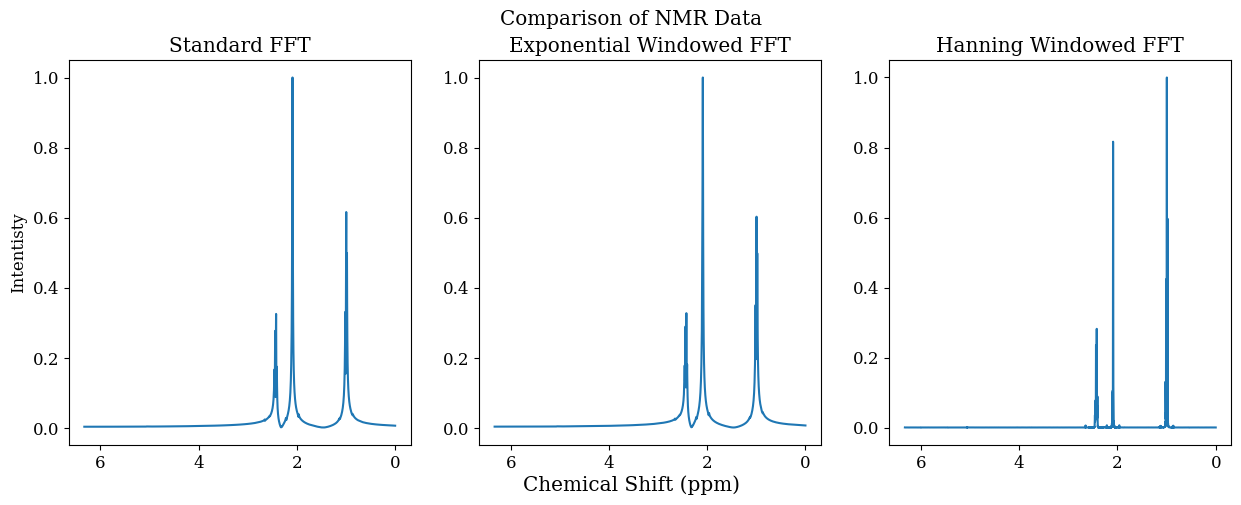

In [25]:
# Plot Side-by-Side (normalized):
fig, (left, center, right) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Comparison of NMR Data\n")
fig.supxlabel("Chemical Shift (ppm)")
left.set_ylabel("Intentisty")

# Standard FFT
left.set_title("Standard FFT")
left.plot(standard_ppm_ref, standard_spec_ref)
left.invert_xaxis()

# Exponential Windowed FFT
center.set_title("Exponential Windowed FFT")
center.plot(e_ppm_ref, e_signal_ref)
center.invert_xaxis()

# Hanning Windowed FFT
right.set_title("Hanning Windowed FFT")
right.plot(h_ppm_ref, h_signal_ref)
right.invert_xaxis()

hwindow = [h_ppm_ref, h_signal_ref]
np.save("hwindow.npy", hwindow, allow_pickle=True)

plt.show()

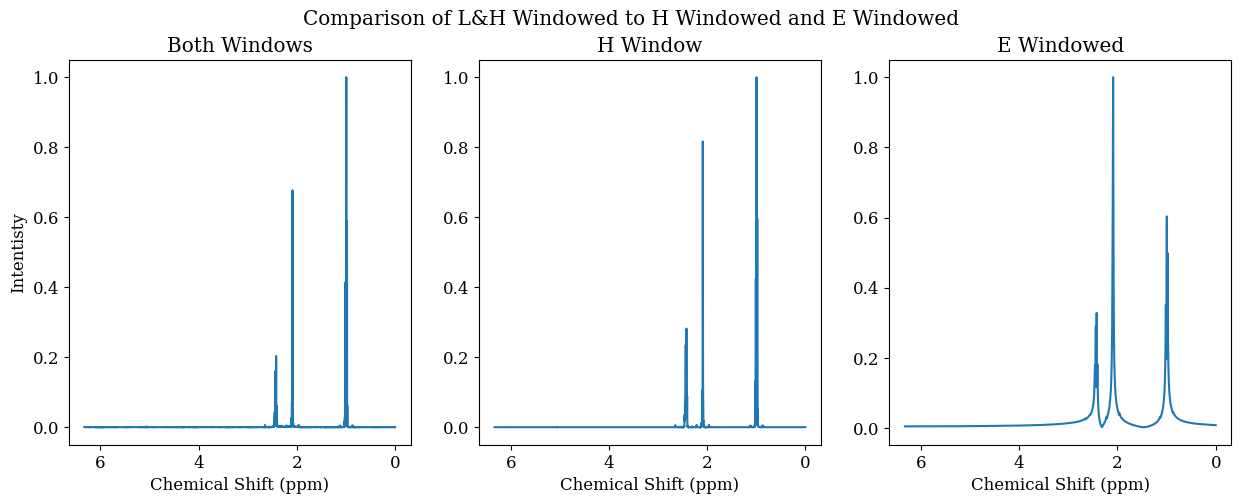

In [37]:
##################################################

# Combine the approaches from above below:
# Remember the pre-windowed fid is : zf_fid

##################################################

# Make Hanning Window
hw = np.hanning(len(zf_fid))

# Make Exponential Window
#ew = sci.exponential(len(zf_fid), tau=1000, sym=False, center=0)

# Make Lanczos window
lw = sci.lanczos(len(zf_fid)) # Alternatively, onoe could employ the Lanczos window

# Multiply the Signal by Both Windows
both_signal = zf_fid * hw * lw

# Fourier Transform
combined_spectrum = np.fft.rfft(both_signal)
combined_frequencies = np.fft.rfftfreq(len(both_signal), d=dt)

# Normalize
combined_max = np.abs(combined_spectrum).max()
norm_combined = np.abs(combined_spectrum) / combined_max

# New frequency axis
combined_ppm = combined_frequencies / ref_freq_500 * 10**6

# Reference the spectra
ref_comb_ppm, ref_comb = reference(combined_ppm, norm_combined)

np.save("ref.npy", [ref_comb_ppm, ref_comb], allow_pickle=True)

# Plot - Done for you
fig, (left, center, right) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Comparison of L&H Windowed to H Windowed and E Windowed")
left.set_ylabel("Intentisty")

left.set_title("Both Windows")
left.plot(ref_comb_ppm, ref_comb)
left.set_xlabel("Chemical Shift (ppm)")
left.invert_xaxis()

center.set_title("H Window")
center.plot(h_ppm_ref, h_signal_ref)
center.set_xlabel("Chemical Shift (ppm)")
center.invert_xaxis()

right.set_title("E Windowed")
right.plot(l_ppm_ref, l_signal_ref)
right.set_xlabel("Chemical Shift (ppm)")

right.invert_xaxis()

### Questions 9-15
9. In the space below, use the plotting skills you have developed in these activities to zoom into each of the peaks. How many distinct peaks make up each multiplet?

**See below for plotting example. The left signal has 4 peaks. The central signal has 1. The right signal has 3.**

10. Explain how processing the data prior to doing a Fourier transform impacted the resultant spectrum.

**The zero-padding improved the resolution of the spectrum, and the windowing functions highlighted the signals while decreasing the noise (increased the signal to noise ratio)**

11. How does the spectrum generated here compare to NMR spectra you are used to seeing from software such as Mnova or TopSpin (NMR processing software)?

**Responses will vary. Students may note factors including the signal to noise ratio, lack of signal integration, peak width/height, and others.**

12. In your own words, explain the role of the Fourier Transform in generating an NMR spectrum.

**The Fourier Transform is responsible for taking in the time-domain data generated from the FID of a molecule and converting it into the frequency-domain.**

13. Why might collecting data in the time domain be experimentally advantageous compared to collecting data directly in the frequency domain?

**Collecting data in the time-domain has many advantages. For example, it allows one to simulataneously measure all frequency components, making this method faster than scanning various frequencies under a fixed magnetic field (as in continuous-wave NMR). Additionally, capturing time-domain data allows one to utilize the Fourier toolkit (e.g., windowing, filtering) to enhance the resolution of the frequency domain spectra.**

14. As mentioned above, you have been working with real experimental $^1$H NMR data collected on a 500 MHz spectrometer of an unknown compound. Assign the spectrum and determine the identity of the molecule if its chemical formula is $\text{C}_4\text{H}_8\text{O}$?

**The molecule is 2-butanone (methyl-ethyl-ketone). The left signal (quartet) is the methylene protons (the CH2 of the ethyl group). The center signal (singlet) is the methyl protons of the methyl group. The right signal (triplet) is the terminal methyl protons of the ethyl group.**

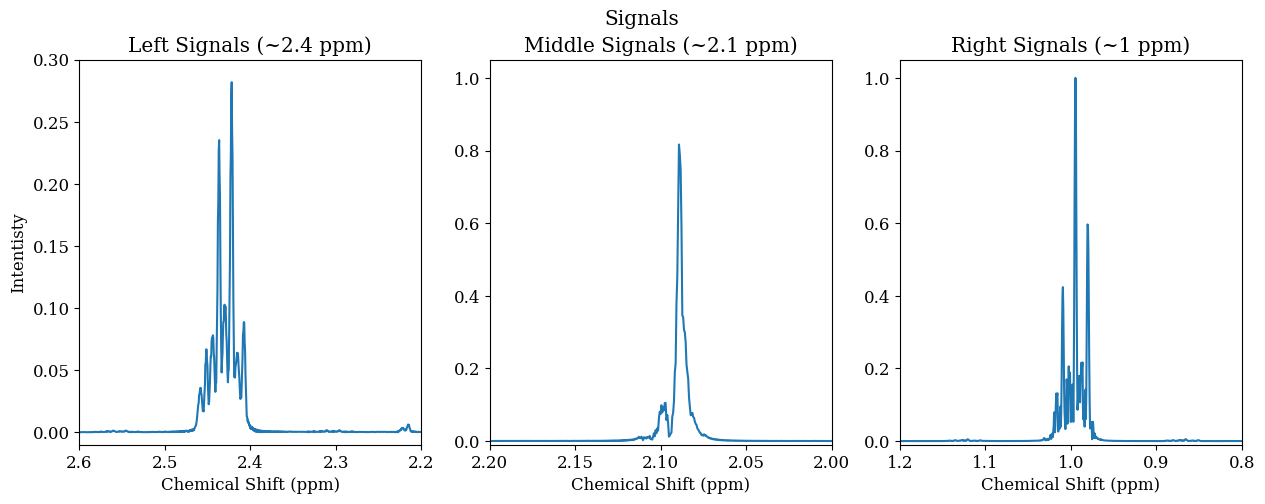

In [38]:
# Plot
fig, (left, center, right) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Signals")
left.set_ylabel("Intentisty")

left.set_title("Left Signals (~2.4 ppm)")
left.plot(h_ppm_ref, h_signal_ref)
left.set_xlabel("Chemical Shift (ppm)")
left.set_xlim(2.2, 2.6)
left.set_ylim(-0.01, 0.3)
left.invert_xaxis()

center.set_title("Middle Signals (~2.1 ppm)")
center.plot(h_ppm_ref, h_signal_ref)
center.set_xlabel("Chemical Shift (ppm)")
center.set_xlim(2, 2.2)
center.set_ylim(-0.01, 1.05)
center.invert_xaxis()

right.set_title("Right Signals (~1 ppm)")
right.plot(h_ppm_ref, h_signal_ref)
right.set_xlabel("Chemical Shift (ppm)")
right.set_xlim(0.8, 1.2)
right.set_ylim(-0.01, 1.05)
right.invert_xaxis()